In [1]:
import os

import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, chi2, SelectPercentile, SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA, SparsePCA
import scipy.stats

%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def load_datasets():
    datasets = dict()
    dataset_names = []
    for filename in os.listdir('data'):
        path = os.path.join('data', filename)
        dname, ext = filename.split('.')
        if dname in ['PHQ9_GAD7_df', 'PCL5_df']:
            sep=';'
        else:
            sep=','
        if ext == 'csv':
            datasets[dname] = pd.read_csv(path, sep=sep)
        elif ext == 'xlsx':
            datasets[dname] = pd.read_excel(path)
        dataset_names.append(dname)
        print(f"Loaded {filename} as {dname}")
    return datasets, dataset_names

In [3]:
# set some constants
RANDOM_STATE=42
TESTSIZE = 0.2
VALSIZE = 0.2
# number of features to select
NUMFEATURES = 5
# or a top percentile of features by importance to select
PERCFEATURES = 20
# name of the target columns
TARGET = 'CONDITION'

In [4]:
# probably not used anymore but i spent too much time on this to delete it 
# also looks cool so idc

from itertools import combinations

def gen_interaction_combinations(
    col_names: list[str],
    max_order,
) -> list[tuple[str]]:
    """
    Generate all possible combinations of orders [1,...,max_order].\n
    Used to add interactions to the data.
    """
    res = []
    for order in range(1,max_order):
        res.append(list(combinations(col_names, order + 1)))
    return res

def calc_interaction(
    data: pd.DataFrame, 
    cols: list
) -> pd.Series:
    """ 
    Multiply specified columns of a dataframe.\n
    Returns a new series.
    """
    res = pd.Series(data=np.ones(data.shape[0]))
    for c in cols:
        res *= data[c]
    return res

def add_interactions(
    df: pd.DataFrame,
    col_names: list[str],
    max_order: int = 0
) -> pd.DataFrame:
    """
    Add all possible interactions between specified columns up to some order.\n
    """
    res = df.copy()

    assert max_order >= 0
    if max_order == 0:
        max_order = len(col_names)
        
    if max_order == 1:
        return res

    all_ints = gen_interaction_combinations(col_names=col_names, max_order=max_order)
    for ints_ord_i in all_ints:
        for inter in ints_ord_i:
            new_col = calc_interaction(df,inter)
            res['.'.join(map(str,inter))] = new_col
    return res

#### Preprocessing

In [5]:
def separate_target(data:np.ndarray, target_ind:int):
    return data[:,:target_ind], data[:,target_ind]

def check_split_integrity(
    data: pd.DataFrame,
    x_train: np.ndarray,
    x_val: np.ndarray, 
    x_test: np.ndarray,
    train_size: float = 1-VALSIZE-TESTSIZE, 
    val_size: float = VALSIZE, 
    test_size: float = TESTSIZE
    ):
    assert x_train.shape[1] == data.shape[1] - 1
    assert x_val.shape[1] == data.shape[1] - 1
    assert x_test.shape[1] == data.shape[1] - 1

    assert x_train.shape[0] + x_val.shape[0] + x_test.shape[0] == data.shape[0]
    assert abs(x_train.shape[0] - int(train_size*data.shape[0])) <= 1
    assert abs(x_val.shape[0] - int(val_size*data.shape[0])) <= 1
    assert abs(x_test.shape[0] - int(test_size*data.shape[0])) <= 1

    return

def preprocess(
    data: pd.DataFrame, 
    target_column: str,
    val_size: float=VALSIZE, 
    test_size: float=TESTSIZE, 
    random_state: float=RANDOM_STATE,
    scale: bool=False,
    center: bool=False
):
    """
    Function that combines all preprocessing steps.\n
    Returns a dict with the training, validation and test sets as numpy arrays.\n
    """
    data_trainval, data_test = train_test_split(data, test_size=test_size,random_state=random_state, shuffle=True, stratify=data[target_column])
    data_train, data_val = train_test_split(data_trainval, test_size=val_size/(1-test_size),random_state=random_state, shuffle=True, stratify=data_trainval[target_column])
    predictors_pipeline = Pipeline(steps=[
        ('scale_numerics', StandardScaler(with_mean=center, with_std=scale))
    ])
    target_pipeline = Pipeline(steps=[
        ('encode_target', sklearn.preprocessing.OrdinalEncoder())
    ])
    preprocessor = ColumnTransformer([
        ('predictors', predictors_pipeline, data.columns[data.columns != target_column]),
        ('target', target_pipeline, [target_column])
    ], remainder='passthrough')

    data_train_pr = preprocessor.fit_transform(data_train)
    data_val_pr = preprocessor.transform(data_val)
    data_test_pr = preprocessor.transform(data_test)

    res = dict()
    target_index = data.columns.get_loc(target_column)
    res['train'] = separate_target(data_train_pr, target_index)
    res['val'] = separate_target(data_val_pr, target_index)
    res['test'] = separate_target(data_test_pr, target_index)

    return res

#### Plotting functions

In [6]:
def make_title(dname, fnames):
    if type(fnames) == list:
        algs = ' and '.join((', '.join(fnames[:-1]), fnames[-1]))
        return f'Validation performance comparison on {dname} with {algs}'
    elif type(fnames) == str:
        algs = fnames
        return f'Validation performance on {dname} with {algs}'

In [69]:
def draw_scores(scores, model_names,  metric_name, fig_title=None, alg_names=None, draw_difference=False, draw_hline=True):
    """
    Parameters:\n

    scores - either a dataframe of scores for each model, or a list of such dataframes (for comparison between feature selection algs)
    """
    f = plt.figure(figsize=(10,5*len(model_names)), constrained_layout=True)
    #f.tight_layout(h_pad=5, w_pad=5)
    subfigs = f.subfigures(nrows=len(model_names), ncols=1)
    nmodels = len(model_names)
    for row, subfig in enumerate(subfigs):
        
        subfig.suptitle(f"Model: {model_names[row]}")
        if draw_difference:
            ax = subfig.add_subplot(1,2,1)
        else:
            ax = subfig.add_subplot(1,1,1)
        
        # if type(scores) == list and np.shape(scores[0]) != len(model_names) and np.shape(scores[1]) == len(model_names):
        if type(scores) != list:
            scores_ = [scores]
        else:
            scores_ = scores
        
        for model_scores in scores_:
            ax.plot(model_scores.columns.to_numpy(), model_scores.iloc[row])
            if draw_hline:
                ax.axhline(y=model_scores.iloc[row][model_scores.columns[-1]], linestyle='dashed',linewidth=1, label='_nolegend_',c='orange')
        ax.set_ylabel(metric_name)
        ax.grid()
        ax1 = ax.twiny()
        ax1.set_xlim(ax1.get_xlim())
        if len(scores_) > 1:
            ax.legend(alg_names)
        
        if draw_difference:
            ax_d = subfig.add_subplot(1, 2, 2)
            ax_d.plot(scores.iloc[row] - scores.iloc[row][scores.columns[-1]])
            ax_d.axhline(y=0, linestyle='dashed',linewidth=1, label='_nolegend_',c='orange')
            ax_d.grid()
            ax_d.set_ylabel('F1 score with full feature set - F1 score')
            ax1_d = ax_d.twiny()
            ax1_d.set_xlim(ax1_d.get_xlim())
            if len(scores_) > 1:
                ax_d.legend(alg_names)

        if row == 0:
            ax1.set_xlabel("Proportion of components retained")
            if draw_difference:
                ax.set_title('Validation performance')
                ax_d.set_title('Difference between validation performance on' \
                        + '\n reduced and original data')
                ax1_d.set_xlabel("Proportion of components retained")
        elif row == nmodels-1:
            ax.set_xlabel("N of components retained")
            if draw_difference:
                ax_d.set_xlabel("N of components retained")

    # for p in percentile_locations:
    #     ax.axvline(x=p, linestyle='dashed', c='black', alpha=0.1, label='_nolegend_')
    # f.subplots_adjust(top=0.8)
    if not fig_title is None:
        f.suptitle(fig_title, fontsize=15)
    return f

def draw_pca_results(pca):
    f, (ax,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax.grid(axis='y', alpha=0.3)
    ax.bar(range(1, pca.explained_variance_ratio_.shape[-1] + 1), pca.explained_variance_ratio_, align='center',
        label='Individual explained variance')
    ax.set_ylim(bottom=0, top=1.05)
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    #ax1.set_ylim(bottom = pca.explained_variance_ratio_[0]/2.5, top = 1.0)
    ax1.step(range(1, pca.explained_variance_ratio_.shape[-1] + 1), np.cumsum(pca.explained_variance_ratio_), where='mid',
            label='Cumulative explained variance', color='red')
    ax.title.set_text('Explained variance ratio by component')
    ax.set_ylabel('Individual explained variance ratio')
    ax1.set_ylabel('Cumulative explained variance ratio')
    ax.set_xlabel('Principal component index')
    ax.set_xticks(ticks=range(1,pca.n_components_+1))

    ax2.plot(pca.explained_variance_)
    ax2.grid(axis='y', alpha=0.3)
    ax2.title.set_text('Scree Plot')
    ax2.set_xlabel('Eigenvalue index')
    ax2.set_ylabel('Eigenvalue')

    # f.legend(loc='center right')
    f.tight_layout()
    return f

def plot_feature_importances(X, y, feature_names_in, score_func=chi2):
    selector = SelectPercentile(score_func=score_func, percentile=PERCFEATURES)
    selector.fit(X, y)
    ax = plt.figure().add_subplot()
    ax.bar(feature_names_in, selector.scores_)
    ax.set_title(f'Feature importance with {score_func.__name__}')
    ax.set_ylabel('scores')
    ax.set_xlabel('features')
    ax.set_xticklabels(feature_names_in,rotation=45,ha='right')
    
    return ax

def plot_top_features(X, y, k, feature_names_in, score_func):

    assert np.shape(X)[0] == np.shape(y)[0]

    selector = SelectKBest(score_func=score_func, k=k)
    X_t = selector.fit_transform(X,y)
    fnames = selector.get_feature_names_out(input_features=feature_names_in)
    f = plt.figure(figsize=(10, 10))
    if k == 1:
        ax = f.add_subplot(projection='1d')
        ax.scatter(xs=X_t, c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
    if k == 2:
        ax = f.add_subplot()
        ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])
    if k == 3:
        f.tight_layout()
        ax3d = f.add_subplot(2,2,1, projection='3d')
        ax3d.scatter(xs=X_t[:,0],ys=X_t[:,1],zs=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.1)
        ax3d.set_xlabel(fnames[0])
        ax3d.set_ylabel(fnames[1])
        ax3d.set_zlabel(fnames[2])
        ax3d.view_init(elev=28, azim=-47)
        
        ax = f.add_subplot(222)
        # ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])

        ax = f.add_subplot(223)
        # ax.hist2d(x=X_t[:,0],y=X_t[:,2],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[2])

        ax = f.add_subplot(224)
        # ax.hist2d(x=X_t[:,1],y=X_t[:,2],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,1],y=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[1])
        ax.set_ylabel(fnames[2])

        f.subplots_adjust(left=0, right=1, top=1, bottom=0,hspace=0.5)


    # legend_props = [mpl.lines.Line2D([0],[0], marker='o',color='tab:orange'),
    #                 mpl.lines.Line2D([0],[0], marker='o',color='tab:blue')]
    # f.legend(legend_props, ['Honest','Dishonest'],bbox_to_anchor=(1,0.95))
    if score_func == chi2:
        title = 'Top 3 features by Chi2'
    elif score_func == mutual_info_classif:
        title = 'Top 3 features by Mutual Information Criterion'
    elif score_func == lasso_importance:
        title = 'Top 3 features by Logistic Lasso Coefficients'
    elif score_func == rf_importance:
        title = 'Top 3 features by Random Forest Importance'
    f.suptitle(title)

    return f

#### Importance functions

In [8]:
def lasso_importance(X_train, y_train):
    """Importance function that uses Lasso logistic regression coefficients for each feature as scores.\n
    Trained with cross-validation.\n"""
    lasso = sklearn.linear_model.LogisticRegressionCV(
        cv=5,
        random_state=RANDOM_STATE, 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000
    ).fit(X_train, y_train)
    return np.abs(lasso.coef_[0])

def rf_importance(X_train, y_train):
    """Importance function that uses Random Forest coefficients for each feature as scores.\n
    Trained with cross-validation.\n"""
    rf = GridSearchCV(sklearn.ensemble.RandomForestClassifier(random_state=RANDOM_STATE), param_grid={'n_estimators': [10,50,100,200]})
    rf.fit(X_train, y_train)
    return rf.best_estimator_.feature_importances_


#### Experiment helper functions

In [9]:
def compute_on_cv(X, y, func, n_folds=5, shuffle=False, random_state=RANDOM_STATE):
    """Computes a specified f-n with cross-validation"""
    folds_x = np.split(X, n_folds,axis=0)
    folds_y = np.split(y, n_folds,axis=0)
    vals = []
    for fold_x, fold_y in zip(folds_x, folds_y):
        fold_val = func(fold_x, fold_y)
        vals.append(fold_val)
    return np.mean(vals,axis=0), np.array(vals)

In [10]:
def spearmanrho(a, b):
    """Spearman Rho coefficient, rank order correlation"""
    if a.shape != b.shape:
        raise Exception('Shapes of a and b not equal')
    n = np.shape(a)[0]
    d = (a - b)**2
    return 1-6*np.sum(d)/(n*(n**2-1))

In [11]:
from sklearn.metrics import accuracy_score, r2_score, f1_score
from sklearn.model_selection import GridSearchCV

def run_exp(
    X_train, y_train, X_val, y_val,
    models,
    selection_func,
    scoring_func,
    percentiles: list = []
):
    n_features_in = X_train.shape[-1]
    scores = np.ndarray(shape=(len(models), n_features_in))
    feature_scores = selection_func(X_train, y_train)
    # test the models' performance on each of the subsets
    for n_features in range(1, n_features_in + 1):
        # dont need to recalculate the feature importances each time so just pass feature_scores
        selector = SelectKBest(lambda X, y: feature_scores, k=n_features)
        selector.fit(X_train, y_train)
        X_train_red = selector.transform(X_train)
        X_val_red = selector.transform(X_val)
        for i in range(len(models)):
            model_reduced = clone(models[i])
            model_reduced.fit(X_train_red, y_train)
            score = scoring_func(y_true = y_val, y_pred=model_reduced.predict(X_val_red))
            scores[i][n_features-1] = score
    
    return scores, feature_scores


In [12]:
from sklearn.decomposition import PCA, FactorAnalysis

def run_pca_exp(X_train, y_train, X_val, y_val, models, scoring_func, use_fa=False):
    n_features_in = X_train.shape[-1]
    # model_scores = pd.DataFrame(columns=list(range(1,n_features_in + 1)),index=list(range(len(models))))
    model_scores = np.ndarray(shape=(len(models), n_features_in))
    scores = np.ndarray(shape=n_features_in)
    if use_fa:
        full_decomp = FactorAnalysis(n_components=n_features_in,random_state=RANDOM_STATE).fit(X_train)
    else:
        full_decomp = PCA(n_components=n_features_in, random_state=RANDOM_STATE).fit(X_train)

    for n_features in range(1, n_features_in+1):
        if use_fa:
            decomp = FactorAnalysis(n_components = n_features, random_state=RANDOM_STATE)
        else:
            decomp = PCA(n_components = n_features, random_state=RANDOM_STATE)
        X_train_r = decomp.fit_transform(X_train)
        X_val_r = decomp.transform(X_val)
        scores[n_features-1] = decomp.score(X_val)
        for i in range(len(models)):
            model_reduced = clone(models[i])
            model_reduced.fit(X_train_r, y_train)
            score = scoring_func(y_true = y_val, y_pred=model_reduced.predict(X_val_r))
            model_scores[i][n_features-1] = score
    return model_scores, scores, full_decomp

### Prepare data

In [13]:
datasets, dataset_names = load_datasets()

Loaded BF_df_CTU.csv as BF_df_CTU
Loaded BF_df_OU.csv as BF_df_OU
Loaded BF_df_V.csv as BF_df_V
Loaded IADQ_df.csv as IADQ_df
Loaded IESR_df.csv as IESR_df
Loaded PCL5_df.csv as PCL5_df
Loaded PHQ9_GAD7_df.csv as PHQ9_GAD7_df
Loaded PRMQ_df.csv as PRMQ_df
Loaded RAW_DDDT.CSV as RAW_DDDT


In [14]:
data_prep = dict()
for dname in list(datasets.keys()):
    data_prep[dname] = preprocess(datasets[dname], TARGET)

### Exploration (IADQ)

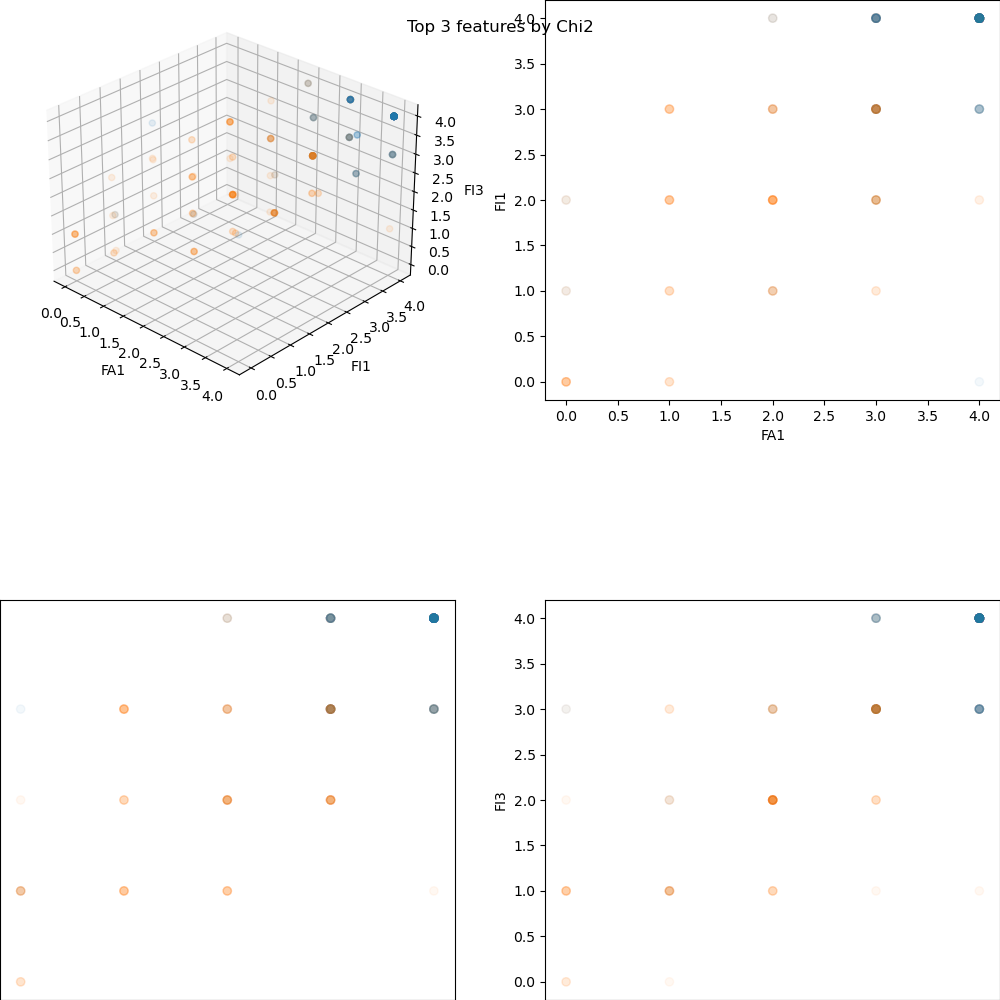

In [131]:
# df_train = pd.DataFrame(iadq['train'][0], columns=rawdata.columns)
f = plot_top_features(data_prep['IADQ_df']['train'][0], data_prep['IADQ_df']['train'][1], 3, datasets['IADQ_df'].columns[:-1],score_func=chi2)

### Feature selection experiments

In [56]:
models = [
    (
        sklearn.svm.SVC(kernel='linear',random_state=RANDOM_STATE),
        {'C':[0.5, 1, 5]}
    ),
    (
        RandomForestClassifier(random_state=RANDOM_STATE),
        {'n_estimators': [10,50,100,200]}
    ),
    (
        sklearn.linear_model.LogisticRegression(random_state=RANDOM_STATE),
        {'C': [0.5,1,5]}
    ),
    (
        sklearn.ensemble.GradientBoostingClassifier(random_state=RANDOM_STATE),
        {'n_estimators': [10,50,100]}
    )
]

models_gs = [GridSearchCV(m, g, n_jobs=-1,scoring='f1_macro') for m,g in models]
model_names = [
    'SVC',
    'Random Forest',
    'Logistic Regression',
    'Gradient Boosting'
]
# List of datasets in which the respondent is expected to fake good
# instead of "default" bad
fake_good = ['']

In [48]:
print('Number of features and number of entries in each dataset:')
for dname in list(datasets.keys()):
    # number of predictors
    p = datasets[dname].shape[1]-1
    # number of items
    n = datasets[dname].shape[0]
    print(f'{dname}: p = {p}, n = {n}, p/n = {p/n}')

Number of features and number of entries in each dataset:
BF_df_CTU: p = 10, n = 442, p/n = 0.02262443438914027
BF_df_OU: p = 10, n = 460, p/n = 0.021739130434782608
BF_df_V: p = 10, n = 486, p/n = 0.0205761316872428
IADQ_df: p = 9, n = 450, p/n = 0.02
IESR_df: p = 22, n = 358, p/n = 0.061452513966480445
PCL5_df: p = 20, n = 402, p/n = 0.04975124378109453
PHQ9_GAD7_df: p = 16, n = 1118, p/n = 0.014311270125223614
PRMQ_df: p = 16, n = 1404, p/n = 0.011396011396011397


#### RFE

In [59]:
scores_rfe = dict()
ranking_rfe = dict()
models_rfe = dict()
for dname in list(datasets.keys()):
    
    d = data_prep[dname]
    feature_range = range(1, d['train'][0].shape[-1]+1)
    
    dataset_rankings = pd.DataFrame(index=model_names, columns = datasets[dname].columns[:-1])
    dataset_scores = pd.DataFrame(index=model_names, columns = feature_range)
    
    for model, mname in zip(models_gs, model_names):
        # Obtain feature rankings according to their importance
        # On each new subset the model is retrained and retuned with the best hyperparams
        if mname == 'Random Forest' or mname == 'Gradient Boosting':
            imp_getter = 'best_estimator_.feature_importances_'
        else:
            imp_getter = 'best_estimator_.coef_'
        rfe = sklearn.feature_selection.RFE(model, n_features_to_select=1, importance_getter=imp_getter)
        rfe.fit(d['train'][0],d['train'][1])
        dataset_rankings.loc[mname] = rfe.ranking_
        # Get the metrics for each of the subsets
        for k in feature_range:
            cols_to_select = np.argwhere(rfe.ranking_ <= k).flatten()
            model.fit(d['train'][0][:,cols_to_select],d['train'][1])
            dataset_scores.loc[mname][k] = sklearn.metrics.f1_score(d['val'][1], model.predict(d['val'][0][:,cols_to_select]))#d['val'][0][:,cols_to_select],d['val'][1])
    print(f'{dname} done')
    
    ranking_rfe[dname] = dataset_rankings
    scores_rfe[dname] = dataset_scores

BF_df_CTU done
BF_df_OU done
BF_df_V done
IADQ_df done
IESR_df done
PCL5_df done
PHQ9_GAD7_df done
PRMQ_df done


In [65]:
# Save the results:
for dname in datasets.keys():
    scores_rfe[dname].to_csv(f'results/{dname}_RFE.csv')
    ranking_rfe[dname].to_csv(f'results/{dname}_rank_RFE.csv')

In [66]:
scores_rfe = dict()
ranking_rfe = dict()
models_rfe = dict()

for dname in datasets.keys():
    scores_rfe[dname] = pd.read_csv(f'results/{dname}_RFE.csv', index_col=0)
    ranking_rfe[dname] = pd.read_csv(f'results/{dname}_rank_RFE.csv',index_col=0)

In [67]:
spearmanrho(ranking_rfe['IADQ_df'].loc['SVC'],ranking_rfe['IADQ_df'].loc['Logistic Regression'])

0.7166666666666667

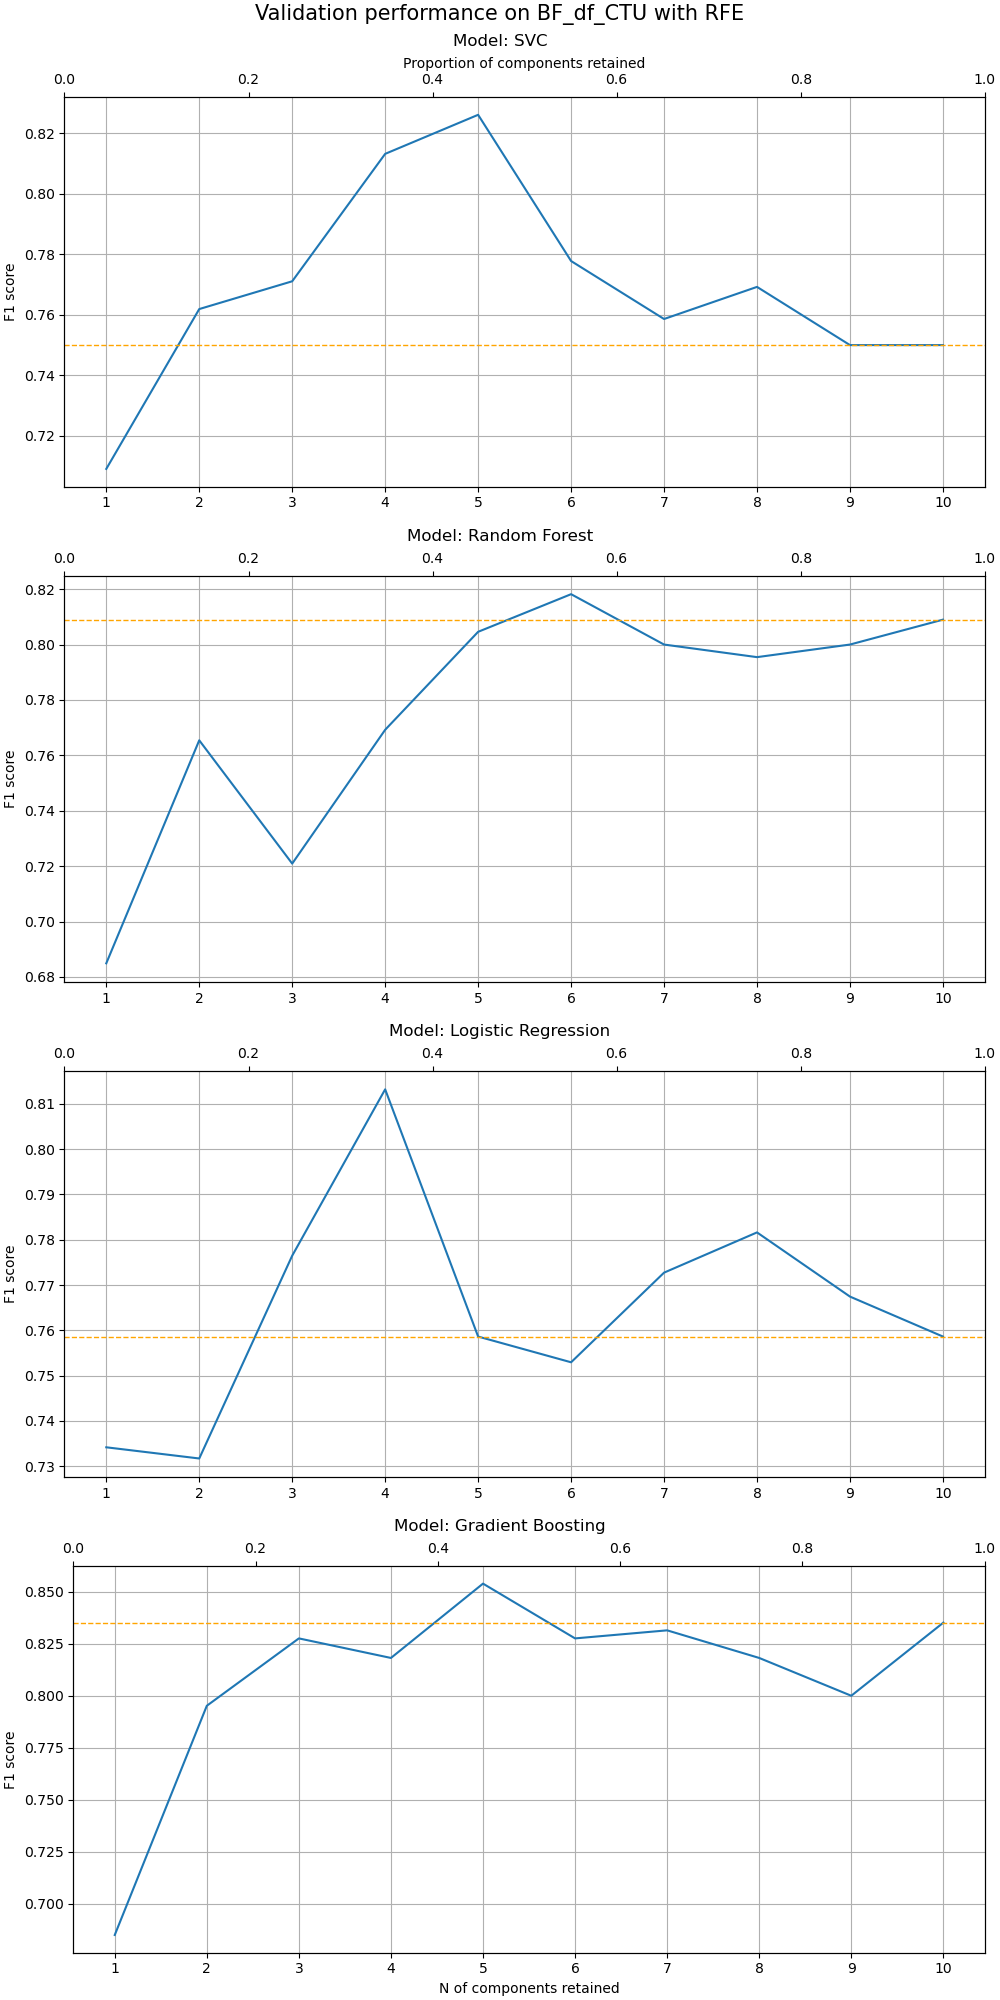

In [158]:
dname_expl = 'BF_df_CTU'
fname = 'RFE'
metric_name = 'F1 score'
title = f'Validation performance on {dname_expl} with {fname}'

f = draw_scores(scores_rfe[dname_expl], model_names, fig_title=title, metric_name=metric_name,draw_difference=False)

### Chisq, MI, Lasso, Random Forest importances

In [86]:
scores_chi2 = dict()
importance_chi2 = dict()
scores_mi = dict()
importance_mi = dict()
scores_lasso = dict()
importance_lasso = dict()
scores_rf = dict()
importance_rf = dict()

In [72]:
# Conduct the experiment

for dname in datasets.keys():
    d = data_prep[dname]
    scores_chi2[dname], importance_chi2[dname]  = run_exp(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models_gs, chi2, accuracy_score)

    scores_mi[dname], importance_mi[dname] = run_exp(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models_gs, mutual_info_classif, accuracy_score)

    scores_lasso[dname], importance_lasso[dname] = run_exp(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models_gs, lasso_importance, accuracy_score)

    scores_rf[dname], importance_rf[dname] = run_exp(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models_gs, rf_importance, accuracy_score)

    print(f'Dataset {dname} done')

Dataset BF_df_CTU done
Dataset BF_df_OU done
Dataset BF_df_V done
Dataset IADQ_df done
Dataset IESR_df done
Dataset PCL5_df done
Dataset PHQ9_GAD7_df done
Dataset PRMQ_df done


In [73]:
# Save the results

for dname in datasets.keys():
    d = data_prep[dname]
    np.savetxt(f'results/{dname}_chi2.csv', scores_chi2[dname], delimiter=',')
    np.savetxt(f'results/{dname}_chi2_imp.csv',importance_chi2[dname][0])
    
    np.savetxt(f'results/{dname}_mi.csv', scores_mi[dname], delimiter=',')
    np.savetxt(f'results/{dname}_mi_imp.csv',importance_mi[dname])
    
    np.savetxt(f'results/{dname}_lasso.csv', scores_lasso[dname], delimiter=',')
    np.savetxt(f'results/{dname}_lasso_imp.csv',importance_lasso[dname])
    
    np.savetxt(f'results/{dname}_rf.csv', scores_rf[dname], delimiter=',')
    np.savetxt(f'results/{dname}_rf_imp.csv',importance_rf[dname])

    # np.savetxt(f'results/{dname}_gb.csv', scores_gb[dname], delimiter=',')
    # np.savetxt(f'results/{dname}_gb_imp.csv',importance_gb[dname])

In [87]:
for dname in datasets.keys():
    scores_chi2[dname] = pd.read_csv(f'results/{dname}_chi2.csv', names=range(1,len(datasets[dname].columns)))
    importance_chi2[dname] = np.loadtxt(f'results/{dname}_chi2_imp.csv')

    scores_mi[dname] = pd.read_csv(f'results/{dname}_mi.csv', names=range(1,len(datasets[dname].columns)))
    importance_mi[dname] = np.loadtxt(f'results/{dname}_mi_imp.csv')

    scores_lasso[dname] = pd.read_csv(f'results/{dname}_lasso.csv', names=range(1,len(datasets[dname].columns)))
    importance_lasso[dname] = np.loadtxt(f'results/{dname}_lasso_imp.csv')

    scores_rf[dname] = pd.read_csv(f'results/{dname}_rf.csv', names=range(1,len(datasets[dname].columns)))
    importance_rf[dname] = np.loadtxt(f'results/{dname}_rf_imp.csv')

In [88]:
# Rank the features by importance
# Remark: chi2 returns p-values as well as importance values

ranking_chi2 = dict()
ranking_mi = dict()
ranking_lasso = dict()
ranking_rf = dict()

for dname in list(datasets.keys()):
    ranking_chi2[dname] = np.array(-1*importance_chi2[dname]).argsort().argsort()
    ranking_mi[dname] = np.array(-1*importance_mi[dname]).argsort().argsort()
    ranking_lasso[dname] = np.array(-1*importance_lasso[dname]).argsort().argsort()
    ranking_rf[dname] = np.array(-1*importance_rf[dname]).argsort().argsort()

In [89]:
spearmanrho(ranking_chi2['IADQ_df'],ranking_mi['IADQ_df'])

0.6

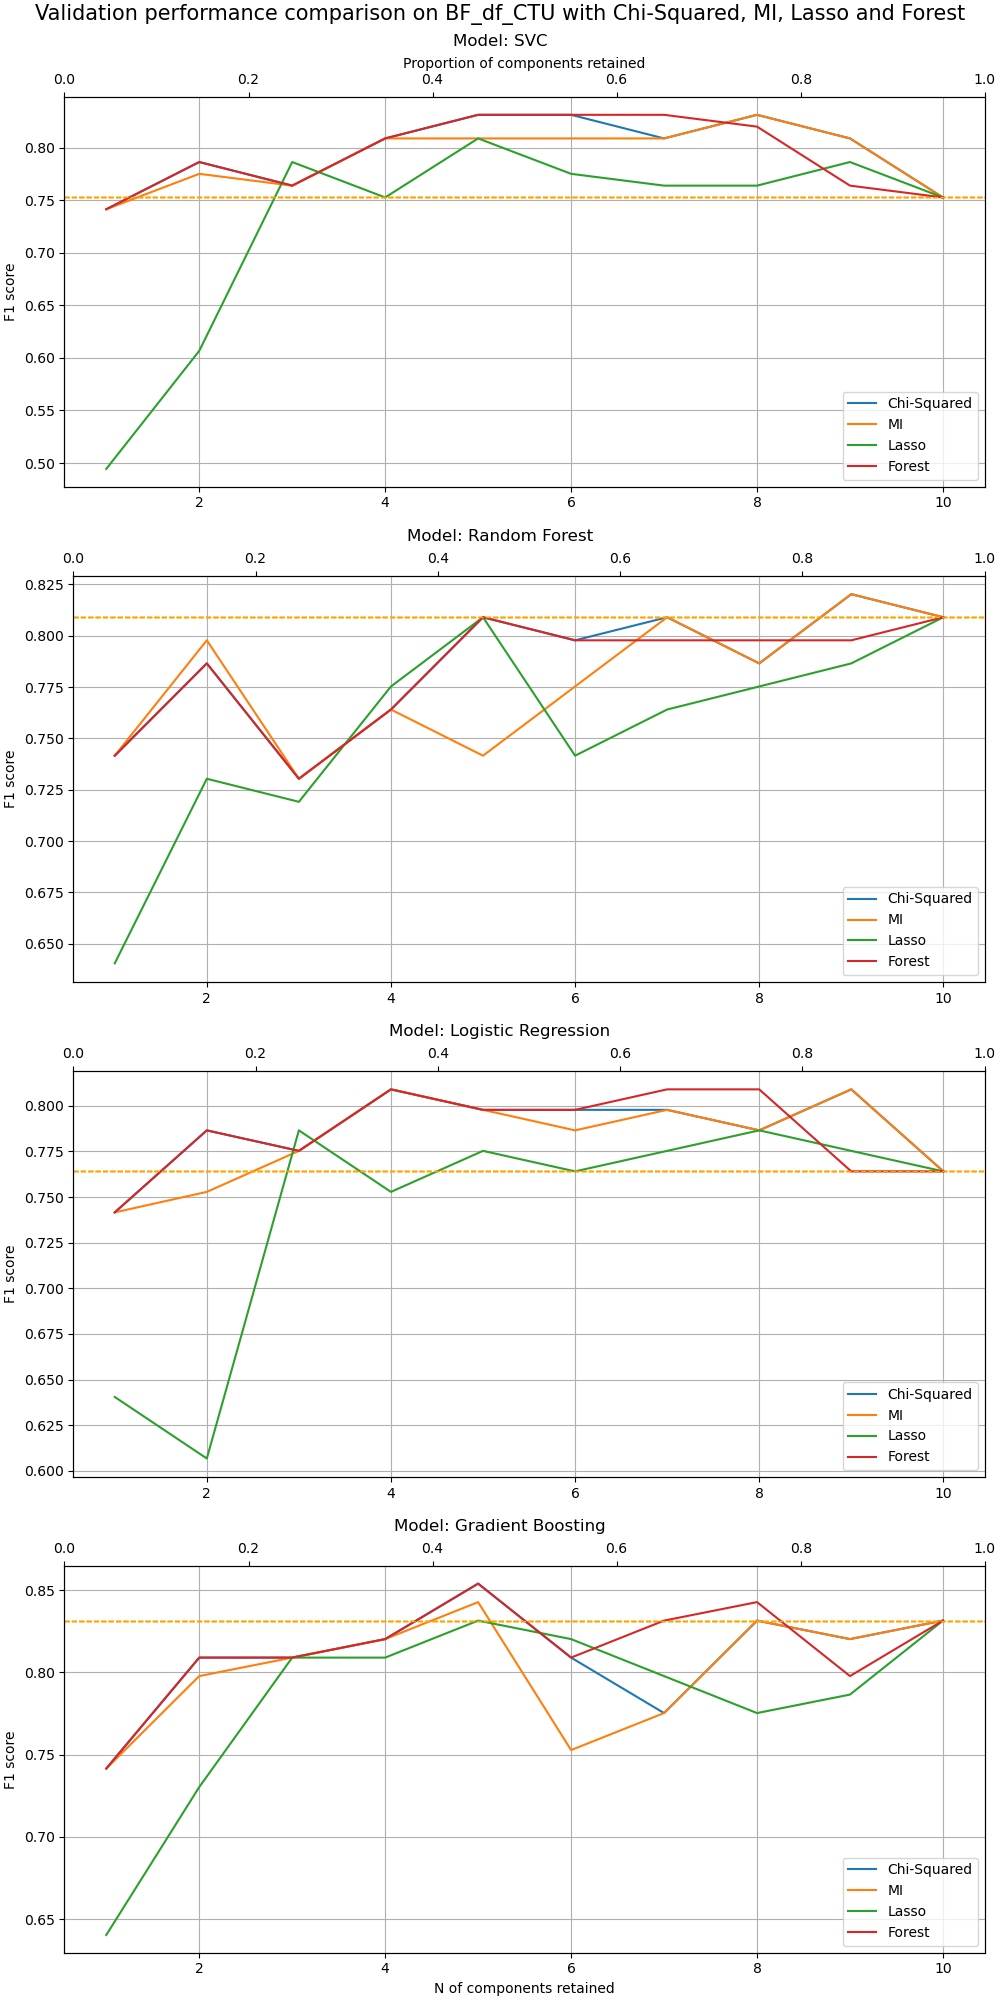

In [159]:
dname_expl = 'BF_df_CTU'
algnames = ['Chi-Squared', 'MI', 'Lasso', 'Forest']
figtitle = make_title(dname_expl, algnames)

f = draw_scores(
    [scores_chi2[dname_expl], scores_mi[dname_expl], scores_lasso[dname_expl], scores_rf[dname_expl]],
    model_names, 'F1 score', figtitle, alg_names=algnames)

C:\Users\xps\AppData\Local\Temp\ipykernel_18076\1607211960.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


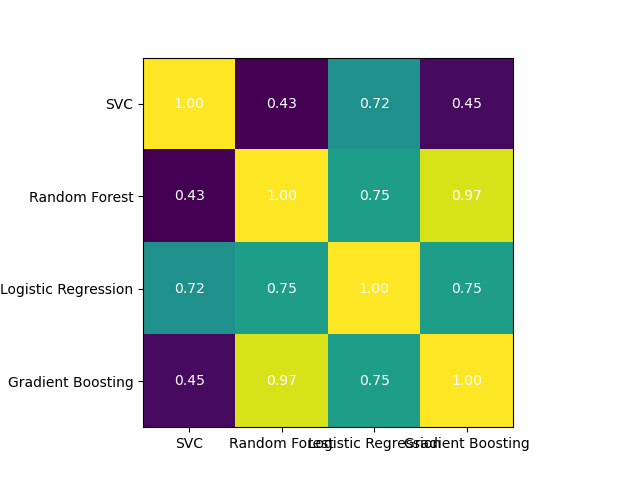

In [91]:
# Plot correlation between model-based methods (RFE)

corrs_rfe = dict()

dname_to_plot = 'IADQ_df'

for dname in datasets.keys():
    corrs_rfe[dname] = np.ndarray(shape = (len(model_names), len(model_names)))
    for i,m1 in enumerate(model_names):
        for j,m2 in enumerate(model_names):
            corrs_rfe[dname][i][j] = spearmanrho(ranking_rfe[dname].loc[m1], ranking_rfe[dname].loc[m2])

fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(model_names)), labels=model_names)
ax.set_yticks(np.arange(len(model_names)), labels=model_names)

for i in range(len(model_names)):
    for j in range(len(model_names)):
        text = ax.text(j, i, '{:.2f}'.format(corrs_rfe[dname_to_plot][i, j]),
                       ha="center", va="center", color="w")

im = ax.imshow(corrs_rfe[dname_to_plot])

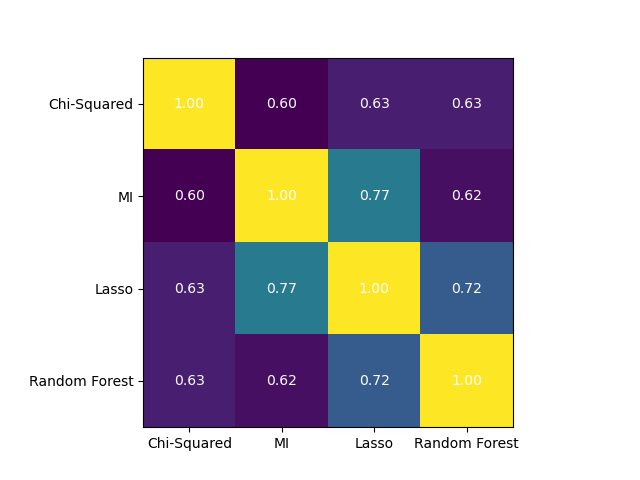

In [92]:
# Plot correlations between model-independent methods

corrs = dict()
mnames = ['Chi-Squared', 'MI', 'Lasso', 'Random Forest']
methods = [ranking_chi2, ranking_mi, ranking_lasso, ranking_rf]

dname_to_plot = 'IADQ_df'

for dname in datasets.keys():
    corrs[dname] = np.ndarray(shape = (len(methods),len(methods)))
    for i,m1 in enumerate(methods):
        for j,m2 in enumerate(methods):
            corrs[dname][i][j] = spearmanrho(m1[dname], m2[dname])

fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(methods)), labels=mnames)
ax.set_yticks(np.arange(len(methods)), labels=mnames)

for i in range(len(methods)):
    for j in range(len(methods)):
        text = ax.text(j, i, '{:.2f}'.format(corrs[dname_to_plot][i, j]),
                       ha="center", va="center", color="w")

im = ax.imshow(corrs[dname_to_plot])

### PCA

In [81]:
import pickle
scores_pca = dict()
decomp = dict()
scores_fa = dict()
decomp_fa = dict()

In [98]:
# Conduct the PCA experiment and save the results
logprobs = dict()
for dname in datasets.keys():
    ds = data_prep[dname]
    scores_pca[dname], logprobs[dname], decomp[dname] = run_pca_exp(ds['train'][0], ds['train'][1], ds['val'][0], ds['val'][1], models_gs, accuracy_score, use_fa=False)
    
    np.savetxt(f'results/{dname}_pca.csv', scores_pca[dname], delimiter=',')
    with open(f'results/{dname}_decomp.pickle', 'wb') as handle:
        pickle.dump(decomp[dname], handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Dataset {dname} done')

Dataset BF_df_CTU done
Dataset BF_df_OU done
Dataset BF_df_V done
Dataset IADQ_df done
Dataset IESR_df done
Dataset PCL5_df done
Dataset PHQ9_GAD7_df done
Dataset PRMQ_df done


In [99]:
# Conduct the FA experiment and save the results
for dname in datasets.keys():
    ds = data_prep[dname]
    scores_fa[dname], _, decomp_fa[dname] = run_pca_exp(ds['train'][0], ds['train'][1], ds['val'][0], ds['val'][1], models_gs, accuracy_score, use_fa=True)
    
    np.savetxt(f'results/{dname}_fact.csv', scores_fa[dname], delimiter=',')
    with open(f'results/{dname}_decomp_fact.pickle', 'wb') as handle:
        pickle.dump(decomp_fa[dname], handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Dataset {dname} done')

Dataset BF_df_CTU done
Dataset BF_df_OU done
Dataset BF_df_V done
Dataset IADQ_df done
Dataset IESR_df done
Dataset PCL5_df done
Dataset PHQ9_GAD7_df done
Dataset PRMQ_df done


In [102]:
# Load PCA and FA data

for dname in datasets.keys():
    scores_pca[dname] = pd.read_csv(f'results/{dname}_pca.csv', names=range(1,len(datasets[dname].columns)))
    scores_fa[dname] = pd.read_csv(f'results/{dname}_fact.csv', names=range(1,len(datasets[dname].columns)))

    with (open(f'results/{dname}_decomp.pickle', "rb")) as openfile:
        while True:
            try:
                decomp[dname] = pickle.load(openfile)
            except EOFError:
                break
    with (open(f'results/{dname}_decomp_fact.pickle', "rb")) as openfile:
        while True:
            try:
                decomp_fa[dname] = pickle.load(openfile)
            except EOFError:
                break

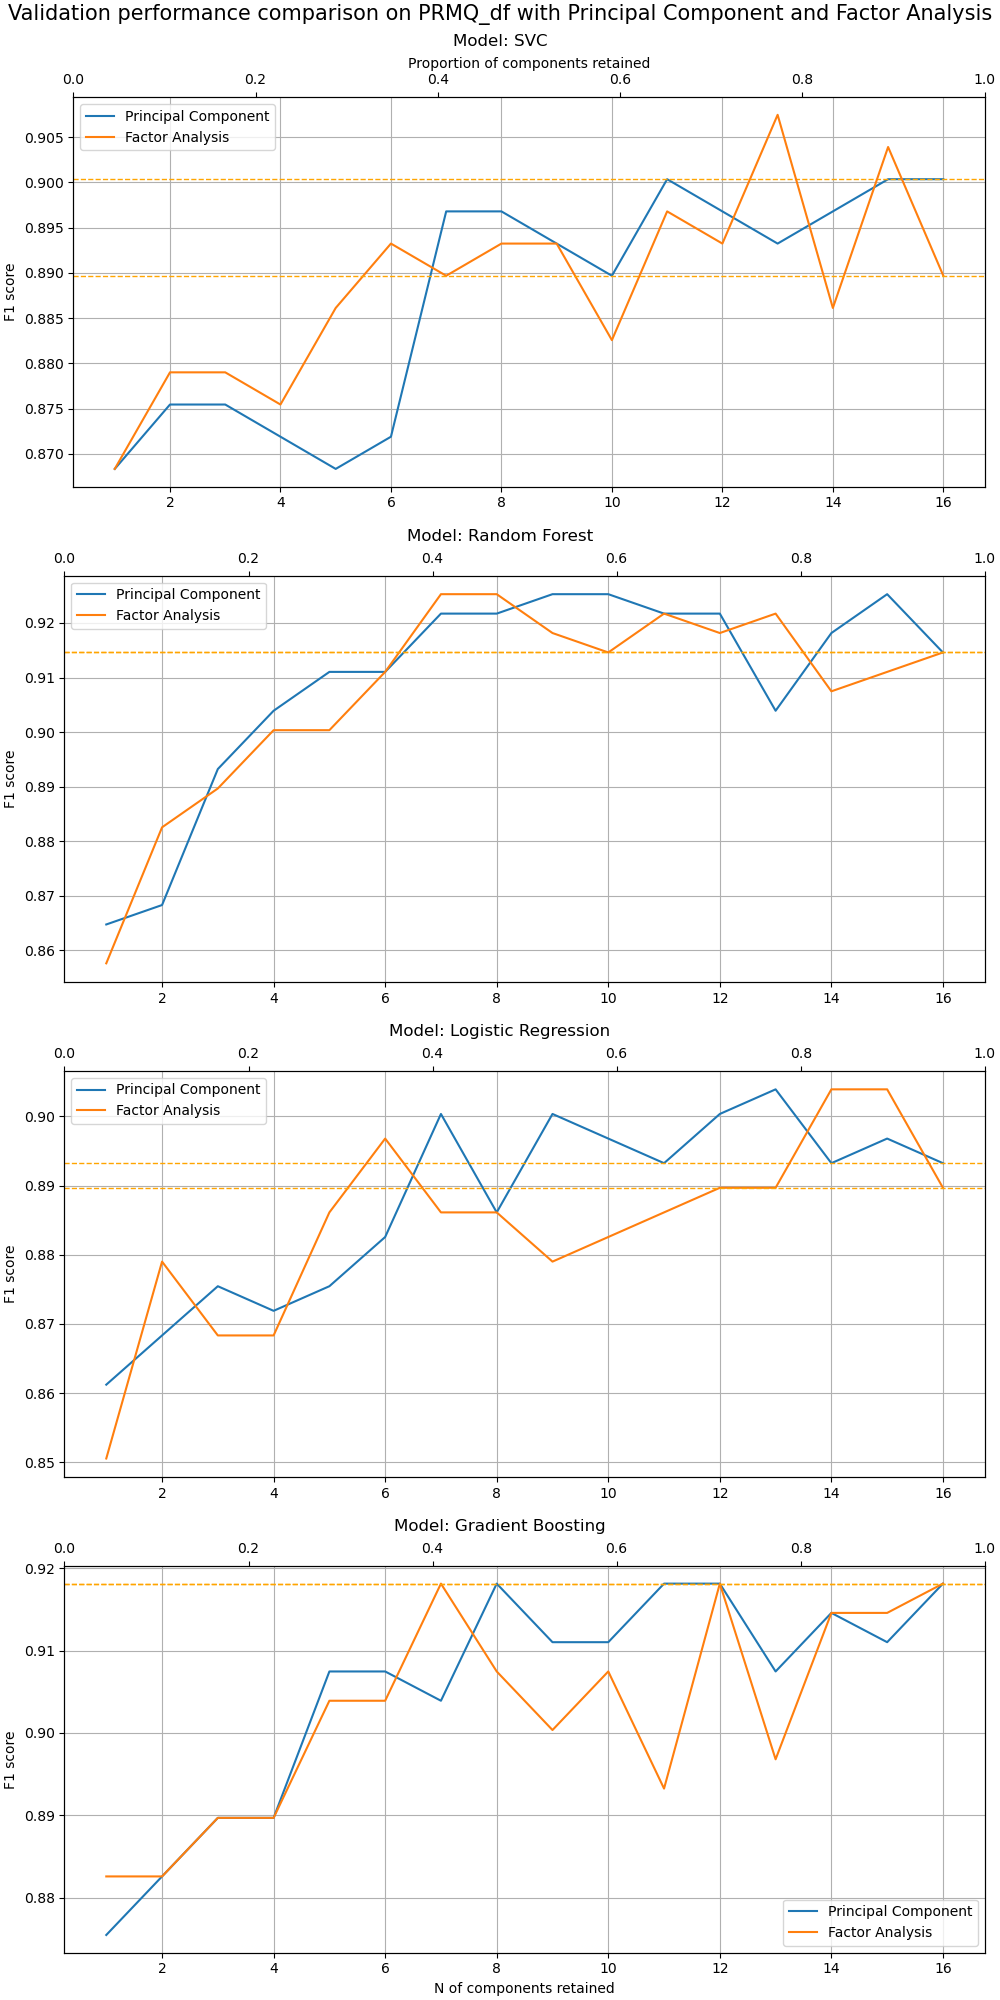

In [128]:
metric_name = 'F1 score'
alg_names = ['Principal Component', 'Factor Analysis']
title = make_title(dname_expl, alg_names)

f = draw_scores(
    [scores_pca[dname_expl], scores_fa[dname_expl]], 
    model_names, fig_title=title, metric_name=metric_name, alg_names=alg_names, draw_difference=False,draw_hline=True
)

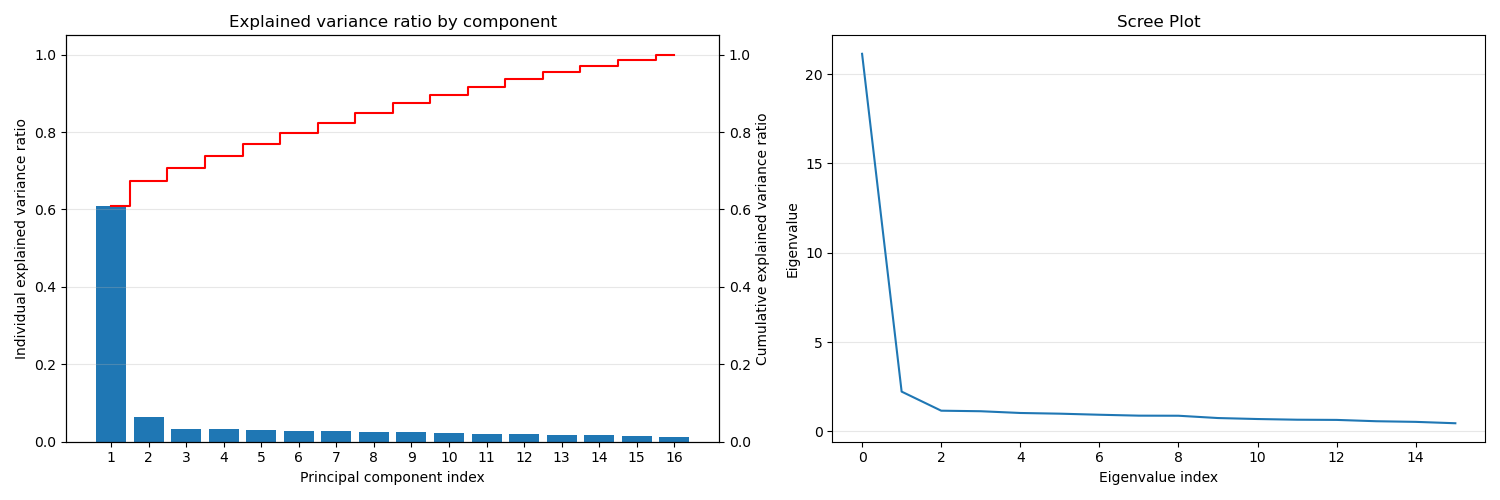

In [94]:
f = draw_pca_results(decomp[dname_expl])

<AxesSubplot:>

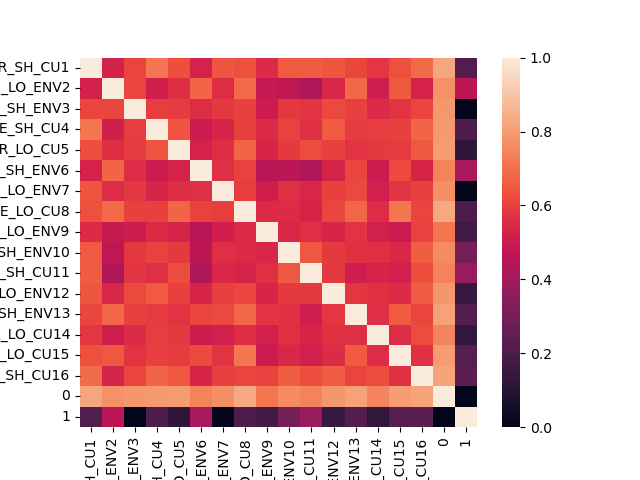

In [141]:
# Select the number of components using the Elbow Method according to the Scree plot
import seaborn as sns

dec_elbow = PCA(n_components=2, random_state=RANDOM_STATE)
data_elbow = dec_elbow.fit_transform(data_prep[dname_expl]['train'][0], data_prep[dname_expl]['train'][1])

data_total = pd.concat([
    pd.DataFrame(data_prep[dname_expl]['train'][0],columns=datasets[dname_expl].columns[:-1])b, 
    pd.DataFrame(data_elbow)], axis=1
    )
fig, ax = plt.subplots()
corr = data_total.corr()
sns.heatmap(np.abs(corr))

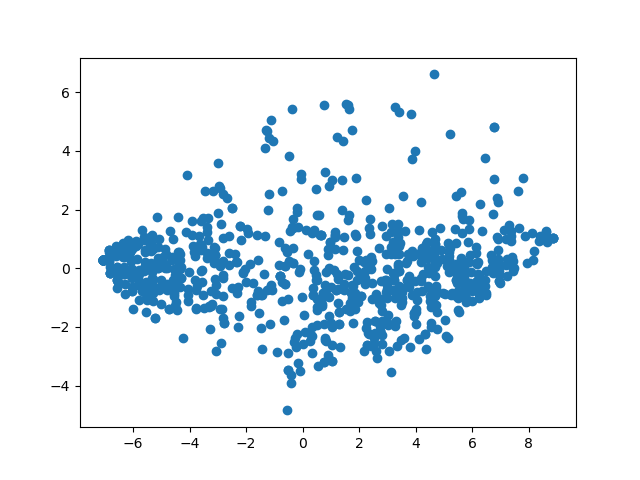

In [157]:
f, ax = plt.subplots()
ax.scatter(decomp[dname_expl].transform(data_prep[dname_expl]['train'][0])[:,0],decomp[dname_expl].transform(data_prep[dname_expl]['train'][0])[:,1])

### Factor Analysis

In [158]:
from sklearn.decomposition import FactorAnalysis
covars = dict()
fa_dict = dict()
for dname in list(datasets.keys()):
    d = preprocess(datasets[dname], TARGET)
    fa = FactorAnalysis(random_state=RANDOM_STATE)
    fa_dict[dname] = fa.fit(d['train'][0])
    covars[dname] = np.cov((d['train'][0] - d['train'][0].mean(axis=0)).T)

In [ ]:
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

n_components = np.arange(1, len(datasets[dname_expl].columns[:-1] ))

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))

def compute_scores(X_t, X_v):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca.fit(X_t)
        pca_scores.append(pca.score(X_v))
        fa.fit(X_t)
        fa_scores.append(fa.score(X_v))

    return pca_scores, fa_scores
pca_scores, fa_scores = compute_scores(data_prep[dname_expl]['train'][0],data_prep[dname_expl]['val'][0])
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

In [ ]:
n_components_pca

In [ ]:
n_components_fa

In [ ]:
fa = FactorAnalysis(n_components=n_components_fa)
fa.fit(data_prep[dname_expl]['train'][0])
xt_fa = fa.transform(data_prep[dname_expl]['train'][0])
xv_fa = fa.transform(data_prep[dname_expl]['val'][0])

pca = PCA(n_components=n_components_fa)
pca.fit(data_prep[dname_expl]['train'][0])
xt_pca = pca.transform(data_prep[dname_expl]['train'][0])
xv_pca = pca.transform(data_prep[dname_expl]['val'][0])


svc = sklearn.svm.SVC()
svc.fit(data_prep[dname_expl]['train'][0],data_prep[dname_expl]['train'][1])
print(svc.score(data_prep[dname_expl]['val'][0],data_prep[dname_expl]['val'][1]))

svc_fa = sklearn.svm.SVC()
svc_fa.fit(xt_fa,data_prep[dname_expl]['train'][1])
print(svc_fa.score(xv_fa,data_prep[dname_expl]['val'][1]))

svc_pca = sklearn.svm.SVC()
svc_pca.fit(xt_pca,data_prep[dname_expl]['train'][1])
print(svc_pca.score(xv_pca,data_prep[dname_expl]['val'][1]))

In [ ]:
n_components_fa

Sparse PCA (PCA + Interpretability)

In [ ]:
spca = SparsePCA(n_components=5,random_state=0)

# class model_evaluator:
#     def __init__(self, models):
#         self.models = models
    
#     def fit(self, X_train, y_train):
#         for model in self.models:
#             model.fit(X_train, y_train)

#     def score(self):
#         scores = model.score()
train, val, test = preprocess(datasets['PRMQ_df'], TARGET)
target_column_ind = datasets['PRMQ_df'].columns.get_loc(TARGET)
X_train, y_train = separate_target(train, target_column_ind)
X_val, y_val = separate_target(val, target_column_ind)
X_test, y_test = separate_target(test, target_column_ind)

# pipe = Pipeline([('SparcePCA', SparsePCA(n_components=5,random_state=0)), ])
spca.fit(X_train)
print(X_train.shape)
X_train_r = spca.transform(X_train)
spca.get_feature_names_out(input_features=datasets['PRMQ_df'].columns[:-1])

OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD

In [ ]:
def build_feature_list(dname):
    return pd.DataFrame({'chi2': features_chi2[dname], 'mi': features_mi[dname], 'lasso': features_lasso[dname], 'f_score': features_f[dname]})

def build_binary_feature_table(dname, percentiles, feature_funs, full_feature_list):
    used_features = build_feature_list(dname)
    df = pd.DataFrame(index=pd.MultiIndex.from_product([percentiles, feature_funs]), columns=full_feature_list)
    for ftre in full_feature_list:
        for fun in feature_funs:
            for per in percentiles:
                if ftre in used_features[fun].loc[per]:
                    df[ftre].loc[(per,fun)] = 1
                else:
                    df[ftre].loc[(per,fun)] = 0
    return df

ft = build_binary_feature_table('IADQ_df', percentiles, feature_funs, np.arange(0,len(datasets['IADQ_df'].columns[:-1])))
prmq_cols = [col.replace('IADQ_df', '') for col in datasets['IADQ_df'].columns[:-1]]
ft.columns = prmq_cols
ft

In [ ]:
scores_f_diff = scores_f.subtract(scores_f[100],axis='index')
scores_rf_diff = scores_rf.subtract(scores_rf[100],axis='index')

scores_chi2_avg = scores_chi2_diff.mean()
scores_mi_avg = scores_mi_diff.mean()
scores_f_avg = scores_f_diff.mean()
scores_lasso_avg = scores_lasso_diff.mean()
scores_rf_avg = scores_rf_diff.mean()
avg_scores = pd.DataFrame({"Chi2": scores_chi2_avg, "MI": scores_mi_avg, 'Lasso': scores_lasso_avg, 'RF': scores_rf_avg, 'F': scores_f_avg})
ax = plt.figure().add_subplot()
ax.plot(scores_chi2_avg.index, scores_chi2_avg)
ax.plot(scores_mi_avg.index, scores_mi_avg)
ax.plot(scores_lasso_avg.index, scores_lasso_avg)
ax.plot(scores_rf_avg.index, scores_rf_avg)
ax.plot(scores_f_avg.index, scores_rf_avg)
ax.axhline(y=0, linestyle='-.', c='red')
ax.legend(['Chi2', 'MI', 'Lasso', 'RF', 'F'])

Let's try adding a new feature: count of 5's in each row.

In [ ]:
expanded_datasets = dict()
for key in datasets.keys():
    expanded_datasets[key] = datasets[key].copy()
    expanded_datasets[key].insert(loc=0, column = 'NMAX', value = datasets[key][datasets[key] == datasets[key].max(axis=0)[:-1].max()].count(1))

In [ ]:
expanded_datasets['IADQ_df']

In [ ]:
train_exp, val_exp, test_exp = preprocess(expanded_datasets['IADQ_df'], TARGET)

to_explore = expanded_datasets['IADQ_df']

target_column_ind = to_explore.columns.get_loc(TARGET)

X_train_exp, y_train_exp = separate_target(train, target_column_ind)
X_val_exp, y_val_exp = separate_target(val, target_column_ind)
X_test_exp, y_test_exp = separate_target(test, target_column_ind)
# check_split_integrity(rawdata, X_train, X_val, X_test)

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = chi2)

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = mutual_info_classif)

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = lasso_importance)

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = rf_importance)

In [ ]:
exp_chi2_scores, exp_chi2_features = eval_for_all_datasets(expanded_datasets, models, model_names, feature_select_func=chi2)

OLD STUFF

In [ ]:
data_exp = add_interactions(rawdata, col_names=['Pr1', 'Pr2', 'Pr3'])
data_exp = add_interactions(data_exp, col_names=['FA1', 'FA2', 'FA3'])
data_exp = add_interactions(data_exp, col_names=['FI1', 'FI2', 'FI3'])

X_exp = data_exp.drop([TARGET],axis=1)
y_exp = data_exp[TARGET]

In [ ]:
X_exp_train, X_exp_tv, y_exp_train, y_exp_tv = train_test_split(X_exp, y_exp, test_size=TESTSIZE,random_state=RANDOM_STATE)

sc_exp = StandardScaler()
X_exp_train = sc_exp.fit_transform(X_exp_train)
X_exp_tv = sc_exp.transform(X_exp_tv)

X_exp_val, X_exp_test, y_exp_val, y_exp_test = train_test_split(X_exp_tv, y_tv, test_size=VALSIZE,random_state=RANDOM_STATE)

In [ ]:
np.sum(y_exp_train == 1)/np.sum(y_exp_train==0)

In [ ]:
# lasso logistic model with no interactions
loglasso = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=1000
).fit(X_train, y_train)

loglasso.score(X_val, y_val)

In [ ]:
loglasso.coef_

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso.coef_.nonzero()[-1]].to_numpy()}')

In [ ]:
# lasso logistic model with interactions
loglasso_exp = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=10000
).fit(X_exp_train, y_exp_train)

loglasso_exp.score(X_exp_val, y_exp_val)

In [ ]:
loglasso_exp.coef_

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso_exp.coef_.nonzero()[-1]].to_numpy()}')

In [ ]:
# ridge regression
logr = LogisticRegression(penalty='l2',random_state=RANDOM_STATE)
rfe = RFE(estimator=logr, n_features_to_select=5, step=1)
X_train_5 = rfe.fit_transform(X_train, y_train)

In [ ]:
X_val_5 = rfe.transform(X_val)
logr_5 = LogisticRegression(penalty='l2', random_state=RANDOM_STATE).fit(X_train_5, y_train)
logr_5.score(X_val_5, y_val)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
random_forest_params =  {
        'n_estimators': [1, 2, 5, 10],
        'max_depth': [1, 2, 3],
        'random_state': [RANDOM_STATE],
    }
model = RandomForestClassifier()
random_forest = GridSearchCV(model, random_forest_params)
random_forest.fit(X_train, y_train)
random_forest.score(X_val, y_val)